### Project 2
Refer to the project writeup [here](https://rutgers.box.com/s/yqrov1mwv5kbpk557nvc5uhjbj4mla6d)

In [3]:
from math import exp
import random

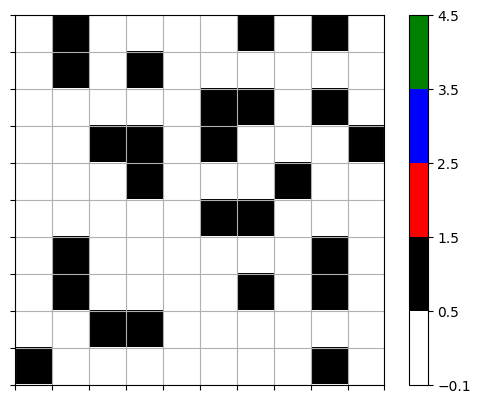

[(1, 4), (0, 3), (0, 5)]

In [2]:
from ship import ship
# Confirming our import works
space_ship = ship.CreateShip(10)
space_ship.OpenShip()
space_ship.ShowShip()
space_ship.getOpenNeighbors((0, 4))

In [4]:
# Now I want to work on bot 3
# Bot 3 and leak have random location on open cells
# If bot takes a "sense" action it has p = e^(-a(d-1)) of getting a beep, given leak is d steps away

# d(i, j) is shortest path to (i, j), all we need to do is SSSP with BFS
def SSSP(ship2: ship, src: tuple):
    dist = {cell :  [float('inf'), []] for cell in ship2.open}
    dist[src] = [0,[]]
    fringe = [src]
    while fringe:
        curr = fringe.pop(0)
        currDist = dist[curr][0]

        for neighbor in ship.getOpenNeighbors(ship2, curr):
            new_dist = 1 + currDist
            if new_dist < dist[neighbor][0]:
                dist[neighbor] = [new_dist, dist[curr][1]+[neighbor]]
                fringe.append(neighbor)
    return dist


# Initially all open cells should have the same probability of containing a leak
# What is P(leak is nearby | beep) = P(beep | leak)*P(leak) / P(beep)

def sense(leakloc, alpha, dist): #Assuming botloc and leakloc are tuples (row, col)
    d = dist[leakloc][0]
    prob = exp(-alpha*(d-1))
    if random.random() < prob:
        return True, prob
    return False, prob

# To determine the next cell we visit:
# - Determine Max P(leak in cell x)
# Put all cells with this probability into a list
# Go to the closest one from this list

def updateProbs(currProbs, senseRes, ship, dist, alpha):
    newProbs = {}
    if senseRes:
        # Find P(beep)
        denom = sum(currProbs[k] * exp(-alpha*(dist[k][0]-1)) for k in ship.open)
    else:
        # Find P(!beep)
        denom = sum(currProbs[k] * (1 - exp(-alpha*(dist[k][0]-1))) for k in ship.open)
    for cell in ship.open:
        init_prob = exp(-alpha * (dist[cell][0]-1))
        if senseRes:
            p_data_evidence = init_prob
        else:
            p_data_evidence = 1-init_prob
        # Essentially, if we get a beep: P(leak in cell)* P(beep at i | leak in cell)/ P(beep)
        new_prob = (currProbs[cell]*p_data_evidence)/denom
        if new_prob > 1: print('we fucked up')
        newProbs[cell] = new_prob
    return newProbs

# Assuming that we went to this cell and we did not find leak
def newCell(cell_loc, currProbs):
    prob_cell = currProbs[cell_loc]
    denom = 1 - prob_cell
    newProbs = {}
    if denom != 0:
        for cell in currProbs.keys():
            newProbs[cell] = currProbs[cell]/denom
    newProbs[cell_loc] = 0
    return newProbs

# Find the cell with max probability, breaking ties by finding min distance
def nextCell(probabilities:dict , distances:dict):
    max_prob = max(probabilities.values())
    max_prob_keys = [key for key,value in probabilities.items() if value==max_prob]
    return min(max_prob_keys, key=lambda key: distances[key][0])

# If we move to a cell and dont detect leak, do we update all probs to be old prob/1 - prob of this cell
def Bot3(ship, alpha):
    opens = list(ship.open)
    while True:
        botloc, leakloc = random.sample(opens, 2)
        if botloc != leakloc: break
    print(f'bot started at: {botloc}, leak is at: {leakloc}')
    start_prob = 1/(len(opens)-1) #Probability leak is in any open cell is 1/# of possible cells
    probs = {cell: start_prob for cell in opens if cell != botloc}
    probs[botloc] = 0
    game_over,t = False,0
    while not game_over:
        distances = SSSP(ship, botloc)
        senseRes,_ = sense(leakloc, alpha, distances)
        t+=1 # Sense action takes one time step
        probs = updateProbs(probs, senseRes, ship, distances,alpha)
        next_cell = nextCell(probs, distances)
        for loc in distances[next_cell][1]:
            botloc = loc
            if loc == leakloc:
                game_over = True
                return game_over, t
            # Set the p(leak in this cell) = 0, and update other probs thru normalization. 
            # Note that this won't change cell with max prob b/c ratio of probabilities will remain the same
            probs = newCell(loc, probs)
            t+=1
        # if set(moves)==ship.open: break # This means something went wrong and we fucked up
    return game_over, t
    


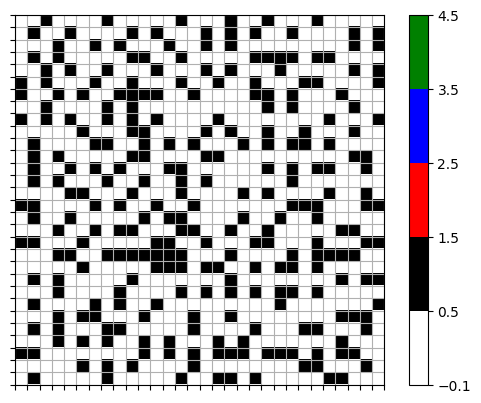

In [43]:
space_ship = ship.CreateShip(30)
space_ship.OpenShip()
space_ship.populateClosedCells()
space_ship.ShowShip()

In [5]:
Bot3(space_ship, 0.05)

bot started at: (1, 8), leak is at: (0, 7)


(True, 127)

In [34]:
# The idea for bot 4. It's going to use pretty much the same logic as bot 3, except it keeps doing sense actions until 
# The max probability goes over some threshhold value. In this way we gain more knowledge about the ship before moving.

def Bot4(ship, alpha, threshold_value=0.5):
    opens = list(ship.open)
    c = 1/alpha #create a failsafe in case there seems to be no higher probability value
    # Sample distinct locations for bot and leak locations
    while True:
        botloc, leakloc = random.sample(opens, 2)
        if botloc != leakloc: break
    print(f'bot started at: {botloc}, leak is at: {leakloc}')
    start_prob = 1/(len(opens)-1) #Probability leak is in any open cell is 1/# of possible cells
    probs = {cell: start_prob for cell in opens if cell != botloc}
    probs[botloc] = 0
    game_over,t, moves = False,0,[botloc]
    while not game_over:
        distances = SSSP(ship, botloc)
        senseRes,_ = sense(leakloc, alpha, distances)
        t+=1 # Sense action takes one time step
        probs = updateProbs(probs, senseRes, ship, distances,alpha)
        max_prob = max(probs.values())
        while max_prob < threshold_value: #till we have found a max_probability cell that is better than what we have set as our threshold we keep sensing 
            senseRes,_ = sense(leakloc, alpha, distances)
            t+=1
            probs = updateProbs(probs, senseRes, ship, distances,alpha)
            max_prob = max(probs.values())
            c-=1
            if c <= 0: #failsafe to stop infinite loops
                break
        next_cell = nextCell(probs, distances)
        for loc in distances[next_cell][1]:
            botloc = loc
            moves.append(loc)
            if loc == leakloc:
                game_over = True
                return game_over, t
            # Set the p(leak in this cell) = 0, and update other probs thru normalization. 
            # Note that this won't change cell with max prob b/c ratio of probabilities will remain the same
            probs = newCell(loc, probs)
            t+=1
        if set(moves)==ship.open: break # This means something went wrong and we fucked up
    return game_over, t

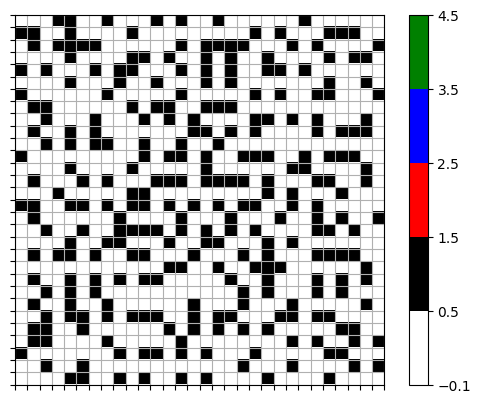

In [27]:
space_ship = ship.CreateShip(30)
space_ship.OpenShip()
space_ship.populateClosedCells()
space_ship.ShowShip()

In [39]:
Bot4(space_ship, 0.05)

bot started at: (26, 25), leak is at: (18, 25)


(True, 74)

In [6]:
# Now let's start coding for Bot 7. Basically, we are going to have same algorithms and methods for updating probabilities
# but now the bot should keep going until it patches up 2 leaks

def Bot7(ship, alpha):
    opens = list(ship.open)
    # Now we initialize two random leak locations that are distinct
    while True:
        botloc, leak1loc, leak2loc = random.sample(opens, 3)
        if len(set([botloc, leak1loc, leak2loc])) == 3: break
    print(f'bot started at: {botloc}, leak 1 is at: {leak1loc}, leak 2 is at: {leak2loc}')
    start_prob = 2/(len(opens)-1)
    probs = {cell: start_prob for cell in opens if cell != botloc}
    probs[botloc] = 0
    leak1found, leak2found,t = False, False,0
    while not leak1found or not leak2found:
        distances = SSSP(ship, botloc)
        # We get sense results first based off the first leak, then once that's found based on the 2nd leak
        if not leak1found:
            senseRes, _ = sense(leak1loc, alpha, distances)
        elif not leak2found:
            senseRes, _ = sense(leak2loc, alpha, distances)
        t+=1
        probs = updateProbs(probs, senseRes, ship, distances,alpha)
        next_cell = nextCell(probs, distances)
        for loc in distances[next_cell][1]:
            botloc = loc
            if loc == leak1loc:
                leak1found = True
            elif loc == leak2loc:
                leak2found = True
            if leak1found and leak2found:
                return True, t
            # Set the p(leak in this cell) = 0, and update other probs thru normalization. 
            # Note that this won't change cell with max prob b/c ratio of probabilities will remain the same
            probs = newCell(loc, probs)
            t+=1
        # if set(moves)==ship.open: break # This means something went wrong and we fucked up
    return False, t
        

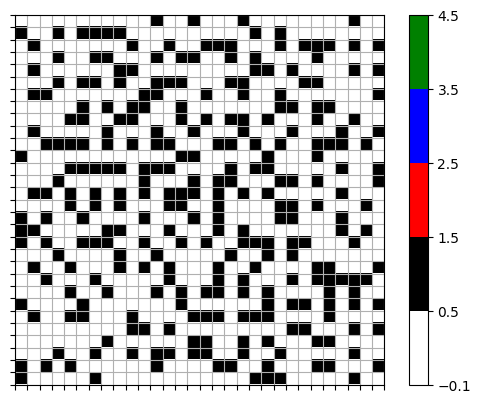

In [50]:
space_ship = ship.CreateShip(30)
space_ship.OpenShip()
space_ship.populateClosedCells()
space_ship.ShowShip()

In [9]:
Bot7(space_ship, 0.05)

bot started at: (1, 2), leak 1 is at: (5, 8), leak 2 is at: (9, 2)


(True, 123)

In [12]:
# The issue is that we have to store probabilities as probability that leak is in any pair. Starting prob is 1/total number of pairs
# This is because leaks are not necessarily dependent

# Once you find a leak can set pairs that don't have 1st leak all to 0. For pairs leak1 and possible leak2

# Switch bot 8 to bot 9 because this is just an approximation where we assume that leaks are independent

# Use alpha between 0.01 and 0.1

# For bot 8, we need to correct the probability of even getting a beep, and we need to correctly
# update probabilities given a sense action. From there we can reuse SSSP(), newCell(), and nextCell()

# Now we compute probability of getting a beep given leak locations is 1 - P(No beep from leak1 AND No beep from leak2)
def sense9(leak1loc, leak2loc, alpha, dist):
    _, prob1 = sense(leak1loc, alpha, dist) #P(beep | leak location)
    _, prob2 = sense(leak2loc, alpha, dist)
    final_prob = 1 - (1-prob1)*(1-prob2)
    if random.random() < final_prob:
        return True, final_prob
    return False, final_prob

def updateProbs9(senseRes,currProbs, ship2, dist, alpha):
    opens = list(ship2.open)
    newProbs = {}
    denom = 0
    for a in range(len(opens)):
        for b in range(a+1, len(opens)):
            if a != b:
                # Finding P(beep at i | leak in a, b)
                _, prob_beep = sense9(opens[a], opens[b], alpha, dist)
                # Probability a and b contain leaks
                prob_ab = currProbs[opens[a]]*currProbs[opens[b]]
                if senseRes:
                    denom += prob_ab*prob_beep
                else:
                    denom += prob_ab*(1-prob_beep)
    for cell in ship2.open:
        p_leak = currProbs[cell]
        if senseRes:
            p_numerator = sum(p_leak*currProbs[k]*sense9(cell, k, alpha, dist)[1] for k in ship2.open if k != cell)
        else:
            p_numerator = sum(p_leak*currProbs[k]*(1 - sense9(cell, k, alpha, dist)[1]) for k in ship2.open if k != cell)
        new_prob =  p_numerator/denom
        if new_prob > 1: print('we fucked up')
        newProbs[cell] = new_prob
    return newProbs


def Bot9(ship, alpha):
    opens = list(ship.open)
    # Now we initialize two random leak locations that are distinct
    while True:
        botloc, leak1loc, leak2loc = random.sample(opens, 3)
        if len(set([botloc, leak1loc, leak2loc])) == 3: break
    print(f'bot started at: {botloc}, leak 1 is at: {leak1loc}, leak 2 is at: {leak2loc}')
    start_prob = 2/(len(opens)-1)
    probs = {cell: start_prob for cell in opens if cell != botloc}
    probs[botloc] = 0
    leak1found, leak2found,t = False, False,0
    while not leak1found and not leak2found:
        distances = SSSP(ship, botloc)
        senseRes,_ = sense9(leak1loc, leak2loc, alpha, distances)
        t+=1
        probs = updateProbs9(senseRes, probs, ship, distances, alpha)
        next_cell = nextCell(probs, distances)
        for loc in distances[next_cell][1]:
            botloc=loc
            if loc == leak1loc:
                leak1found = True
            elif loc == leak2loc:
                leak2found = True
            # Set the p(leak in this cell) = 0, and update other probs thru normalization. 
            # Note that this won't change cell with max prob b/c ratio of probabilities will remain the same
            probs = newCell(loc, probs)
            t+=1
    print("Got out of first while loop")
    # Once one of the leaks is found we can treat this exactly like bot 3
    if not leak1found:
        leak1found, t = mini_bot3(ship, botloc, leak1loc, alpha, t, probs)
    elif not leak2found:
        leak2found, t = mini_bot3(ship, botloc, leak2loc, alpha, t, probs)
    game_over = leak1found and leak2found
    return game_over, t
    return False, t # We should never hit this condition
        
    

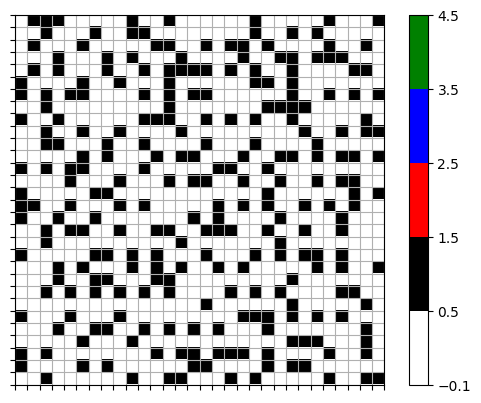

In [55]:
space_ship = ship.CreateShip(30)
space_ship.OpenShip()
space_ship.populateClosedCells()
space_ship.ShowShip()

In [18]:
Bot9(space_ship, 0.05)

bot started at: (1, 7), leak 1 is at: (3, 0), leak 2 is at: (9, 7)
Got out of first while loop


(True, 75)

In [21]:
from KB import KnowledgeBase

kb = KnowledgeBase()
kb.get_probability_for_pair(0, 0)

0

In [19]:
# Now we compute probability of getting a beep given leak locations is 1 - P(No beep from leak1 AND No beep from leak2)
def sense8(leak1loc, leak2loc, alpha, dist):
    _, prob1 = sense(leak1loc, alpha, dist) #P(beep | leak location)
    _, prob2 = sense(leak2loc, alpha, dist)
    final_prob = 1 - (1-prob1)*(1-prob2)
    if random.random() < final_prob:
        return True, final_prob
    return False, final_prob

# Im assuming sense8 is correct but updateProbs8 is not, now note that currProbs is a KnowledgeBase obj
def updateProbs8(senseRes,currProbs, ship2, dist, alpha):
    denom=0
    for pair, prob in currProbs.probs.items():
        loc1,loc2 = pair
        if senseRes:
            _,mult = sense8(loc1,loc2,alpha,dist)
        else:
            _,mult = sense8(loc1,loc2,alpha,dist)
            mult = 1-mult
        denom+=prob*mult            

    new_kb = KnowledgeBase()
    for pair, prob in currProbs.probs.items():
        loc1, loc2 = pair
        if senseRes:
            numerator = prob*sense8(loc1,loc2, alpha, dist)[1]
        else:
            numerator = prob*(1 - sense8(loc1,loc2, alpha, dist)[1])
        new_prob = numerator/denom
        new_kb.add_prob_pair(loc1,loc2, new_prob)
    return new_kb

 # Find next cell by looking at pairs with max probability in the knowledge base and finding nearest cell in those pairs
def nextCell8(knowledge, dist):
    max_prob_cells = knowledge.get_max_locations()
    return min(max_prob_cells, key=lambda cell: dist[cell][0])

# Convert knowledge base of pair probabilities to probabilities of individual cells containing a leak b/c we are done
# We are really finding p(leak 2 in cell | leak 1 in found) = p(leak cell, found)/ p(leak 1 in found) = p(leak cell, found)
def collapseKB(kb, ship, found_loc):
    probs = {}
    for open_cell in ship.open:
        probs[open_cell] = kb.get_probability_for_pair(found_loc, open_cell)
    return probs

def mini_bot3(ship, botloc, leakloc, alpha, t, probs):
    leakfound=False
    while not leakfound:
        distances = SSSP(ship, botloc)
        senseRes,_ = sense(leakloc, alpha, distances)
        t+=1 # Sense action takes one time step
        probs = updateProbs(probs, senseRes, ship, distances,alpha)
        next_cell = nextCell(probs, distances)
        for loc in distances[next_cell][1]:
            botloc = loc
            if loc == leakloc:
                leakfound = True
                return leakfound, t
            probs = newCell(loc, probs)
            t+=1
    return false, t
    
def Bot8(ship, alpha):
    ship.populateClosedCells()
    ship.populateOpenCells()
    kb = KnowledgeBase()
    kb.genInitKB(ship)
    items_to_del = []
    for pairs, probs in kb.probs.items():
        for loc1, loc2 in [pairs]:
            if loc1 in ship.closed or loc2 in ship.closed:
                x1, y1 = loc1
                x2, y2 = loc2
                # print(loc1)
                # print(loc2)
                # print(f'A closed location was in our knowledge base!!!.\nShip value at location 1: {ship.data[x1][y1]}. ship value at location 2: {ship.data[x2][y2]}')
                items_to_del.append(pairs)
    for item in items_to_del:
        del kb.probs[item]
    
    opens = list(ship.open)
    # Now we initialize two random leak locations that are distinct
    while True:
        botloc, leak1loc, leak2loc = random.sample(opens, 3)
        if len(set([botloc, leak1loc, leak2loc])) == 3: break
    kb.set_obj_pairs(botloc, 0) #set all pairs with current botlocation to 0
    print(f'bot started at: {botloc}, leak 1 is at: {leak1loc}, leak 2 is at: {leak2loc}')
    leak1found, leak2found,t, found_loc = False, False,0, None
    while not (leak1found or leak2found):
        dist = SSSP(ship, botloc)
        senseRes,_ = sense8(leak1loc, leak2loc, alpha, dist)
        t+=1
        kb = updateProbs8(senseRes, kb, ship, dist, alpha)
        next_cell = nextCell8(kb, dist)
        for loc in dist[next_cell][1]:
            botloc = loc
            if loc == leak1loc or loc == leak2loc:
                if loc == leak1loc: 
                    leak1found = True
                elif loc == leak2loc: 
                    leak2found = True
                found_loc=loc
                # Set all the pairs that don't have this location to 0
                kb.set_nonobj_pairs(loc, 0)
            else:
                # If there's no leak here, then all the pairs with this obj in it have p(leak)=0
                kb.set_obj_pairs(loc, 0)
            kb.normalize()
            t+=1
    print('out of first while loop')
    probs = collapseKB(kb, ship, found_loc)
    # From here we treat this exactly like a bot 3 problem:
    if not leak1found:
        leak1found, t = mini_bot3(ship, botloc, leak1loc, alpha, t, probs)
    elif not leak2found:
        leak2found, t = mini_bot3(ship, botloc, leak2loc, alpha, t, probs)
    game_over = leak1found and leak2found
    return game_over, t
        

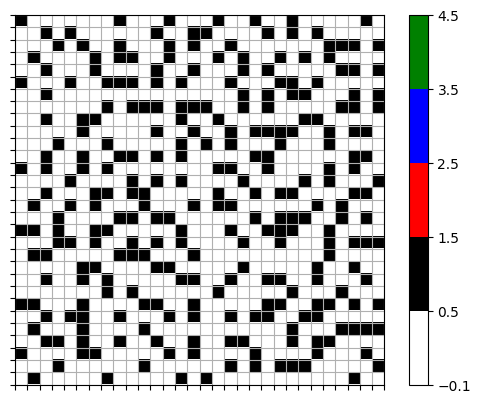

In [58]:
space_ship = ship.CreateShip(30)
space_ship.OpenShip()
space_ship.populateClosedCells()
space_ship.ShowShip()

In [24]:
Bot8(space_ship, 0.05)

bot started at: (2, 1), leak 1 is at: (5, 9), leak 2 is at: (5, 2)
out of first while loop


(True, 104)